In [1]:
# note that packages will be imported along the way as they are needed
import torch
import matplotlib.pyplot as plt

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
dtype = torch.double

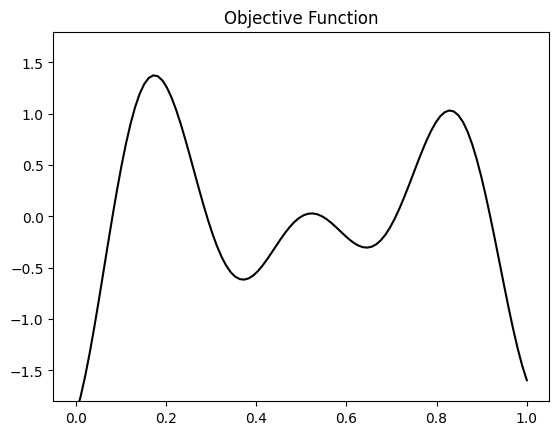

In [3]:
# using a deterministic canonical function often used in optimization

def objective(x):
    x = (x * 10) - 5
    return ((1.4 - 3 * x) * torch.sin(1.5 * x) / 8).to(torch.double)

test_x = torch.linspace(0, 1, 100).double().unsqueeze(-1).to(device)
test_y = objective(test_x)

plt.title("Objective Function")
plt.plot(test_x.cpu(), test_y.cpu(), color="black")
plt.ylim(-1.8, 1.8)
plt.show()

In [4]:
# set up the probabilisitic ML model to use - utility function
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models.transforms import Normalize, Standardize
from botorch import fit_gpytorch_mll # built in automatic training loop

# utility to set up the GP model for use
def initialize_model(train_x, train_obj, state_dict=None):
    """function to initialize the GP model"""
    model_obj = SingleTaskGP(train_x, train_obj, input_transform=Normalize(d=train_x.shape[-1]),
                             outcome_transform=Standardize(m=train_obj.shape[-1]))
    mll = ExactMarginalLogLikelihood(model_obj.likelihood, model_obj)
    # load state_dict if it is not passed
    if state_dict is not None:
        model_obj.load_state_dict(state_dict)
    return mll, model_obj


In [5]:
# sample the initial dataset - utility function
def generate_initial_data(n=10):
    """generate initial set of data to get started with BO loop"""
    train_x = torch.rand(10, 1, device=device, dtype=dtype) # using random uniform sampling on domain [0,1]
    train_obj = objective(train_x)
    best_observed_value = train_obj.max().item()
    return train_x, train_obj, best_observed_value

In [6]:
# set up the botorch built in acquisition function optimization - utility function
# note that the acq opt is combined with sampling the best point (which is returned)
from botorch.optim import optimize_acqf

# hyperparams
NUM_RESTARTS = 10
RAW_SAMPLES = 512
BATCH_SIZE = 1
# bounds on the domain
bounds = torch.tensor([0.0, 1.0], device=device, dtype=dtype).unsqueeze(-1)

def optimize_acqf_and_get_observation(acq_func):
    """Optimizes the acquisition function, and returns a new candidate and a noisy observation"""
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,# initialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )
    # observe new values
    new_x = candidates.detach()
    train_obj = objective(new_x)
    new_obj = train_obj
    return new_x, new_obj

In [7]:
# set up a random selection to use to compare performance - utility function
def update_random_observation():
    """Simulates a random policy
    """
    rand_x = torch.rand(BATCH_SIZE, 1)  # drawing from random uniform
    next_random = objective(rand_x)
    return  rand_x, next_random

In [8]:
# set up the bo optimization loop
import time
from botorch.sampling import SobolQMCNormalSampler
from botorch.acquisition import qLogNoisyExpectedImprovement

N_TRIALS = 2 # 8
N_BATCH = 40 # note +10 for total iteration limit, 120
MC_SAMPLES = torch.Size([256])
N_CANDIDATES = min(5000, max(2000, 200 * 1))
BATCH_SIZE = 1

verbose = True
import warnings
from linear_operator.utils.warnings import NumericalWarning
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=NumericalWarning)
# warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
# warnings.filterwarnings('ignore', category=RuntimeWarning)

# set up arrays to hold arrays of data
# best values
best_observed_all_nei, best_observed_random_all = [], []
# {x, y} values
x_observed_all_random, x_observed_all_nei = [], []
y_observed_all_random, y_observed_all_nei = [], []

# going to average over N_TRIALS
for trial in range(1, N_TRIALS + 1):
    print(f"\nTrial {trial:>2} of {N_TRIALS} ", end="")
    # set up arrays to hold data for this trial
    best_observed_nei, best_observed_random = [], []

    # generate initial training data and initial model for this trial
    # nei
    # use same initial training points
    train_x_nei, train_obj_nei, best_observed_value_nei = generate_initial_data(n=10)
    mll_nei, model_nei = initialize_model(train_x_nei, train_obj_nei)
    # random
    train_x_random, train_obj_random = train_x_nei, train_obj_nei

    # start collection of results from random initialization
    best_observed_nei.append(best_observed_value_nei)
    best_observed_random.append(best_observed_value_nei)

    # for N_BATCH rounds of BO after the initial random batch
    for iteration in range(1, N_BATCH + 1):
        t0 = time.monotonic()
        # fit models
        fit_gpytorch_mll(mll_nei)

        # set up the sampler to use with the acq funcs
        qmc_sampler = SobolQMCNormalSampler(sample_shape=MC_SAMPLES)

        # set up the acquisition functions
        qNEI = qLogNoisyExpectedImprovement(
            model=model_nei,
            X_baseline=train_x_nei,
            sampler=qmc_sampler,
        )

        # optimize the acquisition functions
        new_x_nei, new_obj_nei = optimize_acqf_and_get_observation(qNEI)
        # random
        new_x_random, new_obj_random = update_random_observation()

        # update training points
        train_x_nei = torch.cat([train_x_nei, new_x_nei])
        train_obj_nei = torch.cat([train_obj_nei, new_obj_nei])
        train_x_random = torch.cat([train_x_random, new_x_random])
        train_obj_random = torch.cat([train_obj_random, new_obj_random])

        # update progress data
        best_value_random = train_obj_random.max()
        best_observed_random.append(best_value_random)
        best_value_nei = train_obj_nei.max()
        best_observed_nei.append(best_value_nei)

        # reinitialize the models so that they're ready to fit on the next iteration
        # state dict passed to speed up fitting
        mll_nei, model_nei = initialize_model(
            train_x_nei,
            train_obj_nei,
        )

        t1 = time.monotonic()

        if verbose:
            print(
                f"\nBatch {iteration:>2}: best_value (random, qNEI,) = "
                f"({best_value_random:>4.2f}, {best_value_nei:>4.2f},), "
                f"time = {t1-t0:>4.2f}.", end=""
            )
        else:
            print(".", end="")

    # collect observations from trial
    best_observed_all_nei.append(best_observed_nei)
    best_observed_random_all.append(best_observed_random)
    x_observed_all_random.append(train_x_random)
    x_observed_all_nei.append(train_x_nei)
    y_observed_all_random.append(train_obj_random)
    y_observed_all_nei.append(train_obj_nei)


Trial  1 of 2 
Batch  1: best_value (random, qNEI,) = (0.39, 1.00,), time = 0.88.
Batch  2: best_value (random, qNEI,) = (0.93, 1.31,), time = 0.58.
Batch  3: best_value (random, qNEI,) = (1.00, 1.37,), time = 0.89.
Batch  4: best_value (random, qNEI,) = (1.00, 1.37,), time = 0.92.
Batch  5: best_value (random, qNEI,) = (1.00, 1.37,), time = 0.61.
Batch  6: best_value (random, qNEI,) = (1.00, 1.37,), time = 0.75.
Batch  7: best_value (random, qNEI,) = (1.00, 1.38,), time = 0.77.
Batch  8: best_value (random, qNEI,) = (1.00, 1.38,), time = 2.53.
Batch  9: best_value (random, qNEI,) = (1.00, 1.38,), time = 2.38.
Batch 10: best_value (random, qNEI,) = (1.00, 1.38,), time = 2.20.
Batch 11: best_value (random, qNEI,) = (1.13, 1.38,), time = 1.14.
Batch 12: best_value (random, qNEI,) = (1.13, 1.38,), time = 0.53.
Batch 13: best_value (random, qNEI,) = (1.13, 1.38,), time = 2.08.
Batch 14: best_value (random, qNEI,) = (1.37, 1.38,), time = 1.03.
Batch 15: best_value (random, qNEI,) = (1.37, 

In [9]:
# fit the GP to the data from the final search
fit_gpytorch_mll(mll_nei)
None

Text(0.5, 1.0, 'NEI - Noisy Expected Improvement')

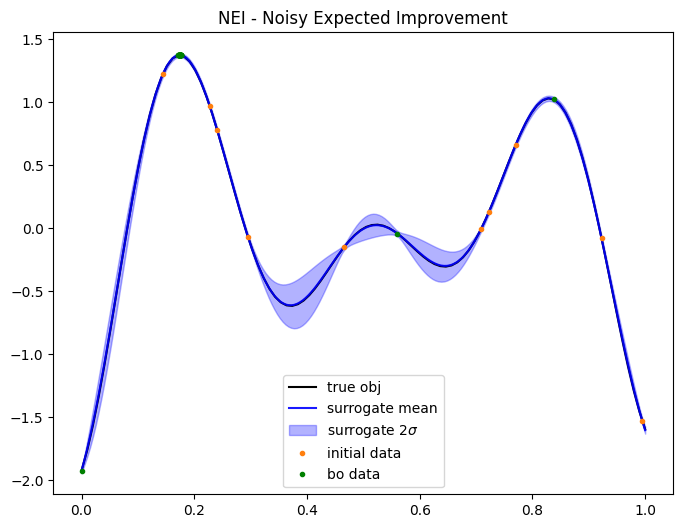

In [12]:
# plot the results for nei
import seaborn as sns
x_test = torch.linspace(0, 1, 200)
f, ax = plt.subplots(1, 1, figsize=(8, 6))
# true objective
plt.plot(test_x.cpu(), test_y.cpu(), color="black", label='true obj')

# final model
nei_gp_posterior = model_nei.posterior(x_test.unsqueeze(-1), observation_noise=True,)
mean_test = nei_gp_posterior.mean.detach().squeeze().numpy()
ax.plot(x_test.numpy(), mean_test, 'b-', alpha=0.9, label='surrogate mean')
lower_test, upper_test = nei_gp_posterior.mvn.confidence_region()
ax.fill_between(x_test.numpy(), lower_test.detach().squeeze(), upper_test.detach().squeeze(),
                color='b', alpha=0.3, label=r'surrogate 2$\sigma$')


# training points
ax.plot(train_x_nei.numpy()[0:10], train_obj_nei[0:10].numpy(), '.', color='tab:orange', label='initial data')
ax.plot(train_x_nei.numpy()[10:], train_obj_nei[10:].numpy(), '.', color='g', label='bo data')
ax.legend()
ax.set_title('NEI - Noisy Expected Improvement')
# plt.savefig(datasavedir + '/'+'nei_final_state'+'.png')

Text(0.5, 1.0, 'MCS - Monte Carlo with Random Uniform Input')

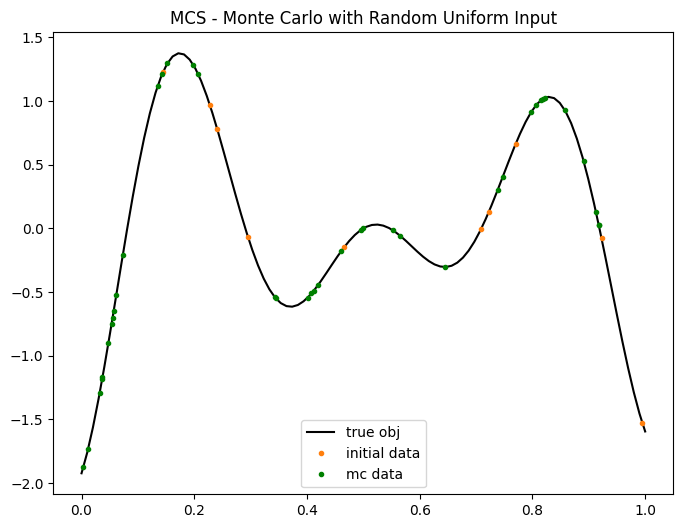

In [13]:
# plot the results for random
x_test = torch.linspace(0,1,200)
f, ax = plt.subplots(1,1, figsize=(8, 6))
# true objective
plt.plot(test_x.cpu(), test_y.cpu(), color="black", label='true obj')

# training points
ax.plot(train_x_random.numpy()[0:10], train_obj_random[0:10].numpy(), '.', color='tab:orange', label='initial data')
ax.plot(train_x_random.numpy()[10:], train_obj_random[10:].numpy(), '.', color='g', label='mc data')
ax.legend()
ax.set_title('MCS - Monte Carlo with Random Uniform Input')